In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.impute import SimpleImputer




In [15]:
batters = pd.read_csv('c:\\Users\\josep\\Portfolio\\DS6021\\DS6021-Project\\data\\cleaned\\final_batters_df.csv')
batters['won_mvp'] = batters['won_mvp'].astype('category')
batters['won_gold_glove'] = batters['won_gold_glove'].astype('category')
batters['won_cy_young'] = batters['won_cy_young'].astype('category')
batters['position'] = batters['position'].astype('category')
batters['won_silver_slugger'] = batters['won_silver_slugger'].astype('category')
batters['all_star'] = batters['all_star'].astype('category')

In [16]:
batters_clean = batters.dropna(subset=["free_agent_salary"])
X = batters_clean.drop(columns=["row_id", "playerID","year","free_agent_salary","free_agent_salary_log",
                          "ZR","position","WP",'all_star',"contract_length",
                          "won_cy_young","won_mvp","won_gold_glove","won_silver_slugger"])
y = batters_clean["free_agent_salary_log"]
imputer = SimpleImputer(strategy="median")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed  = imputer.transform(X_test_raw)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

knn = KNeighborsRegressor()
param_grid = {"n_neighbors":[3,5,7,9,11], "weights":["uniform","distance"]}
grid = GridSearchCV(knn, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train_scaled, y_train)

y_pred = grid.predict(X_test_scaled)

KeyError: "['free_agent_salary_log'] not found in axis"

In [ ]:
print("Best KNN params:", grid.best_params_)

Best KNN params: {'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.5f}")
print(f"Test R^2: {r2:.5f}")

Test MSE: 11699372501188.78516
Test R^2: 0.54648


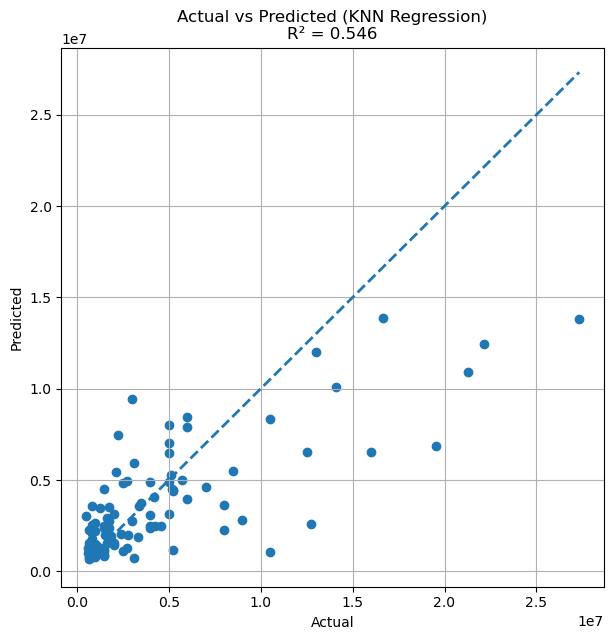

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted (KNN Regression)\nR² = {r2:.3f}")
plt.grid(True)
plt.show()